In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Esta versión considera las siguientes variables:
- Variables predictoras: #edad, años estudio
- Variables de respuesta: Acción, Drama, Romance, Ciencia ficción, Histórica


<font color='gray'>*This version take into account the following variables:*
- *Independent variables:  #edad, años estudio*
- *Dependent variables:  Acción, Drama, Romance, Ciencia ficción, Histórica*</font>

In [3]:
path = 'datasets/peliculas_a.csv'
peliculas_df = pd.read_csv(path, usecols=[0,1, 4,5,6,7,8])

# Análisis

<font color='gray'>*Analysis*</font>

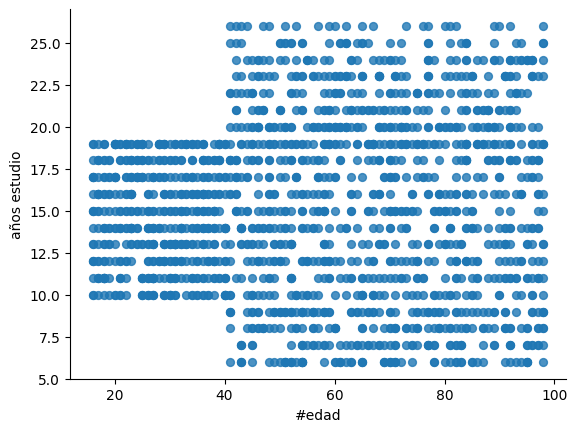

In [5]:
peliculas_df.plot(kind='scatter', x='#edad', y='años estudio', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

,count
años estudio,
6,65
7,61
8,68
9,82
10,97
11,111
12,114
13,107
14,122


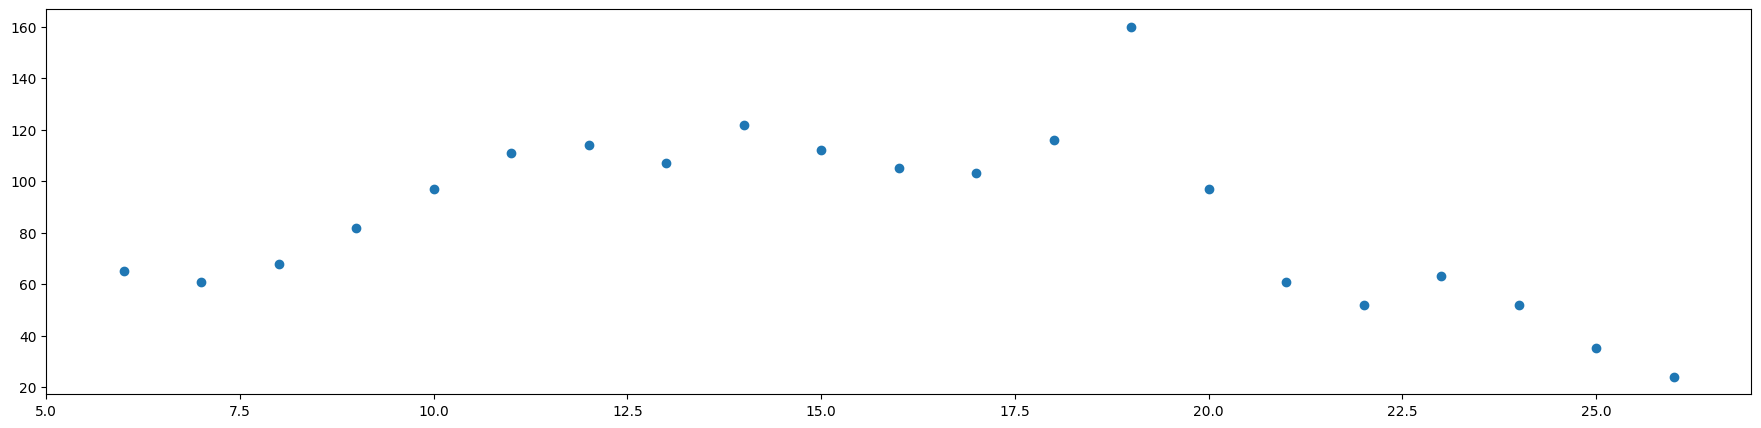

In [6]:
fig_est, ax_est = plt.subplots()

freq_est = peliculas_df[['años estudio', 'Acción']].groupby('años estudio').count()
freq_est = freq_est.rename(columns = {'Acción': 'count'})

ax_est.scatter(freq_est.index, freq_est['count'])
fig_est.set_size_inches(22,5)
freq_est

Parece tener una tendencia más marcada en su distribución. En este caso, parece que hay más personas con años de estudio entre 10 y 20 años; y decrece rapidamente después de eso.

Además parece que no hay correlación entre ambas variables (años de estudio vs edad).

<font color='gray'>*It seems to have a more noticiable tren in its distribution. In this case, there's more people with years of study between 10 and 20 year; and it decreases faster after that point.*

*Moreover, there's no noticiable liniarly correlation between both variables (años estudio vs edad)*</font>

## Correlación

<font color='gray'>*Correlation*</font>

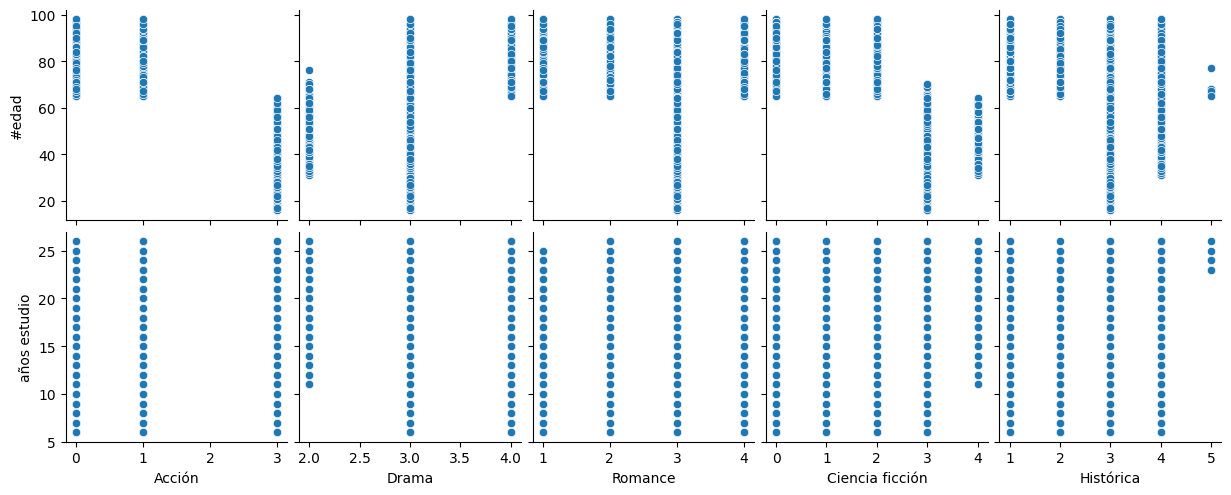

In [9]:
sns.pairplot(data=peliculas_df,
                  x_vars=peliculas_df.columns[2:],
                  y_vars=['#edad', 'años estudio'])
# No parece haber correlación entre los años de estudio y la calificación de cada género.
# No correlation between 'años estudio' and each genre score

<Axes: >

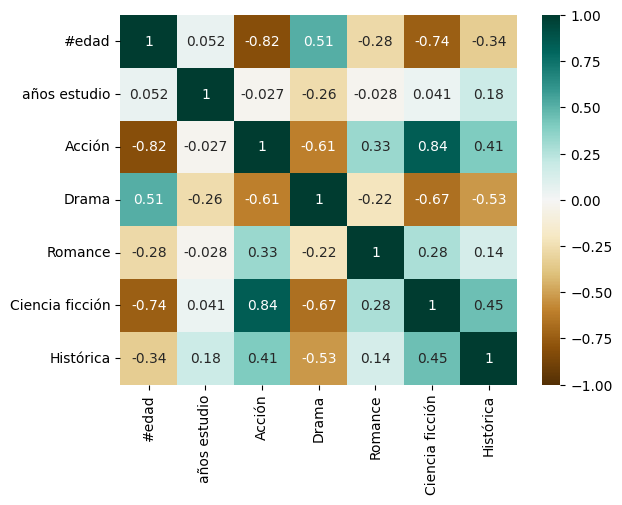

In [12]:
sns.heatmap(peliculas_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
# Y en efecto, no hay correlación.
# There's no correlation to the 'años estudio' variable

# Modelos

Tenemos dos opciones:
1. El modelo para edad
2. Incluir `años estudio` usando vecinos cercanos


<font color='gray'>*Model*

*There are two options:*
1. *The same model as step_one (age)*
2. *Incluiding `años estudio` in KNeighborsClassifier*
</font>


## Model 1 (age modified)

In [18]:
class Recomendador1:
    def __init__(self):
        '''Predictions are ordered as:
            0: Less relevant
            4: More relevant'''
        pass

    def fit(self, X_train, y_train):
        '''
        X_train: (Series) Datos de entrenamiento
        y_train: (DataFrame) Etiquetas de los datos de entrenamiento
        
        '''
        ## Take only the '#edad' column
        X_train = X_train['#edad']

        self.generos = list(y_train.columns)
        train_set = y_train.join(X_train, how = 'inner')

        # Modelo: probabilidad x grupo
        age_groups = train_set.groupby('#edad')
        age_t_points = train_set.groupby('#edad').sum().T.sum() # total points by genre
        probs_by_age = age_groups.sum().apply(lambda col: col / age_t_points) # PDF
        self.model = probs_by_age
        pass

    def predict(self, X_test):
        '''
        X_test: (iterador) Datos de prueba
        '''
        ## Take only the '#edad' column
        X_test = X_test['#edad']
        X_test = pd.Series(X_test)
        # Query the model, sort by probability and returns the ordered list of genres
        y_pred = X_test.apply(lambda age: pd.Series(self.model.loc[age].sort_values().index.values))
        return y_pred

    def score(self, X_test, y_test, y_pred):
        ''' Calcula el valor esperado de casillas correctas de la predicción '''
        ## Take only the '#edad' column
        X_test = X_test['#edad']
        test_set = y_test.join(X_test, how = 'inner')
        test_set = test_set.set_index('#edad')

        # Transform scores -> Ordered genre preference (total preorder)
        self.y_test_transf = test_set.apply(lambda sample: self._transform_sample(sample), axis = 1)

        # compare row by row
        comparing_bool = y_pred.reset_index(drop = True) == self.y_test_transf.reset_index(drop = True)
        number_success_df = pd.DataFrame(comparing_bool.apply(lambda row: row.sum(), axis = 1))
        distrib_success = number_success_df.groupby(0).agg({0: len})
        tot_success = distrib_success.sum().sum()

        distrib_success['p'] = distrib_success[0]/tot_success
        distrib_success['px'] = distrib_success['p'] * distrib_success.index
        self.E = distrib_success['px'].sum()
        return {'Esperanza': self.E}

    def _transform_sample(self, test_set):
        ''' transform score list -> total preordered genres list'''
        # test_set (index: edad, cols: generos)

        df_recomendacion = pd.DataFrame([test_set, self.model.loc[test_set.name]], index = ['cal','p']).T
        df_recomendacion = df_recomendacion.sort_values(['cal','p'])
        recomendacion = df_recomendacion.index.values
        return pd.Series(recomendacion)

In [19]:
# Split sets
X = peliculas_df[['#edad', 'años estudio']]
y = peliculas_df.drop(['#edad', 'años estudio'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2024)

In [20]:
R = Recomendador1()
R.fit(X_train,y_train)
y_predict = R.predict(X_test)
R.score(X_test, y_test, y_predict)

{'Esperanza': 4.320441988950276}

## Model 2 (KNeighborsClassifier)

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier

In [22]:
class Recomendador2:
    def __init__(self):
        '''Predictions are ordered as:
            0: Less relevant
            4: More relevant'''
        pass

    def fit(self, X_train, y_train):
        '''
        X_train: (DataFrame) Datos de entrenamiento
        y_train: (DataFrame) Etiquetas de los datos de entrenamiento
        
        '''
        knn = KNeighborsClassifier(n_neighbors=10)
        self.model = MultiOutputClassifier(knn, n_jobs=-1,)
        self.model.fit(X_train,y_train)
        pass

    def predict(self, X_test):
        '''
        X_test: (iterador) Datos de prueba
        '''
        generos = ['Acción', 'Drama', 'Romance', 'Ciencia ficción', 'Histórica']
        # Convierte X_test a DF
        y_pred = pd.DataFrame(self.model.predict(X_test)) 
        # Acomoda los géneros según el sort_values de sus calificaciones predichas
        y_pred = y_pred.apply(lambda row: pd.Series(row.sort_values().index.map(lambda x: generos[x]).values), axis=1)
        return y_pred

    def score(self, X_test, y_test, y_pred):
        ''' Calcula el valor esperado de casillas correctas de la predicción '''
        y_pred_df = pd.DataFrame(y_pred)

        # Selección de su preferencia en términos de género como preorden total
        self.y_test_transf = y_test.apply(lambda sample: self._transform_sample(sample), axis = 1)

        # Comparar fila x fila
        comparing_bool = y_pred_df.reset_index(drop = True) == self.y_test_transf.reset_index(drop = True)
        number_success_df = pd.DataFrame(comparing_bool.apply(lambda row: row.sum(), axis = 1))
        distrib_success = number_success_df.groupby(0).agg({0: len})
        tot_success = distrib_success.sum().sum()
        tot_success

        distrib_success['p'] = distrib_success[0]/tot_success
        distrib_success['px'] = distrib_success['p'] * distrib_success.index
        self.E = distrib_success['px'].sum()
        return {'Esperanza':self.E, 'Score': self.model.score(X_test,np.array(y_test))}

    def _transform_sample(self, test_set):
        ''' transform score list -> total preordered genres list'''
        # test_set (index: edad, años estudio, cols: generos)
        y_transform = test_set.sort_values().index.values
        return pd.Series(y_transform)

### Testing

In [23]:
R2 = Recomendador2()
R2.fit(X_train,y_train)
y_predict = R2.predict(X_test)
y_predict

,0,1,2,3,4
0,Acción,Drama,Romance,Ciencia ficción,Histórica
1,Acción,Ciencia ficción,Drama,Romance,Histórica
2,Acción,Drama,Romance,Ciencia ficción,Histórica
3,Acción,Ciencia ficción,Romance,Histórica,Drama
4,Acción,Ciencia ficción,Drama,Romance,Histórica
...,...,...,...,...,...
357,Acción,Drama,Romance,Ciencia ficción,Histórica
358,Acción,Drama,Romance,Ciencia ficción,Histórica
359,Acción,Romance,Ciencia ficción,Drama,Histórica
360,Acción,Drama,Romance,Ciencia ficción,Histórica


In [24]:
R2.score(X_test, y_test, y_predict)

{'Esperanza': 3.845303867403315, 'Score': 0.5}